In [4]:
%matplotlib notebook
import os
import numpy as np
from glob import glob
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import nntools as nt
from PIL import Image
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
class imageLoader():
    def __init__(self, root_dir, image_size=(512, 512)):
        self.image_size = image_size
        self.images_dir = root_dir
    def __getitem__(self, idx):
        img = Image.open(self.images_dir)
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            ])
        x = transform(img)
        x = x.unsqueeze(0)
        x.to(torch.float)
        return x.to(device)

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').clone().numpy()
    image = image.squeeze(0)
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


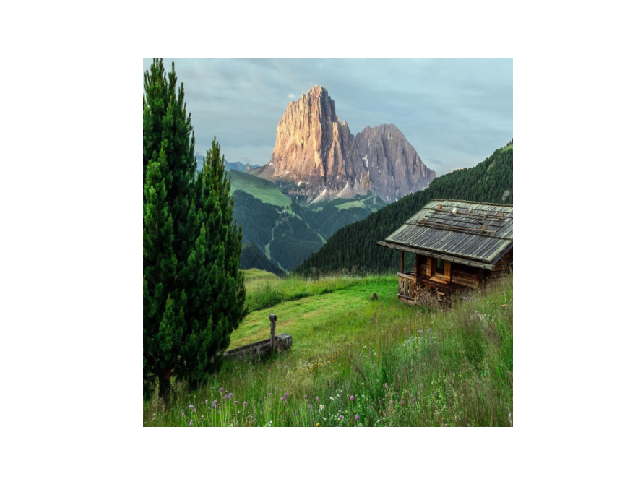

<IPython.core.display.Javascript object>


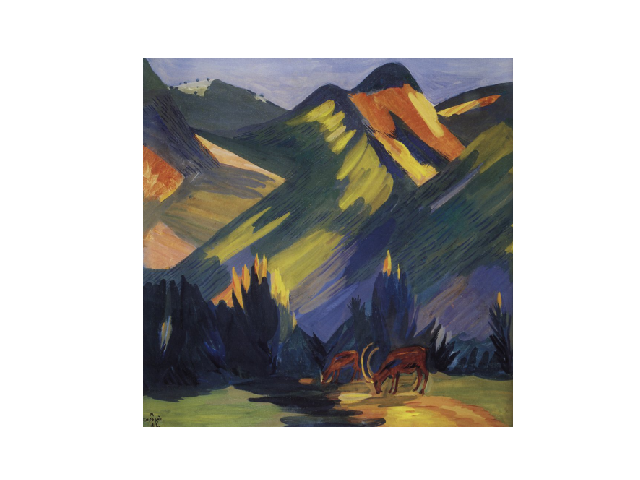

In [8]:
contentImg = imageLoader("timg.jpg")[0]
styleImg = imageLoader("/datasets/ee285f-public/wikiart/wikiart/Expressionism/martiros-saryan_morning-in-stavrin-1912.jpg")[0]
plt.figure()
myimshow(contentImg, ax=plt)
plt.figure()
myimshow(styleImg, ax=plt)

In [9]:
class contentLoss(nn.Module):
    def __init__(self, target):
        super(contentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, input):
        N = input.shape[-1]
        self.loss = F.mse_loss(input, self.target)* N * N * 0.5
        return input

In [10]:
def gram(input):
    batch_size, channel, height, width = input.shape
    x = input.view(batch_size*channel, height*width)
    return torch.mm(x, x.t())/(batch_size*channel)

In [11]:
class styleLoss(nn.Module):
    def __init__(self, target):
        super(styleLoss, self).__init__()
        self.target = target
        
    def forward(self, input):
        target_gram = gram(self.target)
        input_gram = gram(input)
        self.loss = F.mse_loss(input_gram, target_gram)/4
        return input

In [12]:
vgg = tv.models.vgg19(pretrained=True).features.to(device).eval()

In [13]:
def rebuildModel(model, contentImg, styleImg, contentLayers, styleLayers):
    contentLoss_list = []
    styleLoss_list = []

    modelList = nn.Sequential()

    convCount = 0
    poolCount = 0
    reluCount = 0
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            convCount += 1
            name = 'conv_'+str(convCount)
            modelList.add_module(name, layer)
            if name in contentLayers:
                content = modelList(contentImg)
                content_loss = contentLoss(content)
                modelList.add_module("content_loss_"+str(convCount), content_loss)
                contentLoss_list.append(content_loss)

            if name in styleLayers:
                style = modelList(styleImg).detach()
                style_loss = styleLoss(style)
                modelList.add_module("style_loss_"+str(convCount), style_loss)
                styleLoss_list.append(style_loss)
        if isinstance(layer, nn.ReLU):
            reluCount += 1
            name = 'relu_'+str(reluCount)
            layer = nn.ReLU(inplace=False)
            modelList.add_module(name, layer)
        if isinstance(layer, nn.MaxPool2d):
            poolCount += 1
            name = 'pool_'+str(poolCount)
            modelList.add_module(name, nn.AvgPool2d((2,2)))

    return modelList, styleLoss_list, contentLoss_list

In [14]:
def trainer(contentImg, styleImg, epochs, model, contentLayers, styleLayers, beta):
    targetImg = contentImg
    input_param = targetImg.requires_grad_()
    optimizer = optim.LBFGS([input_param])
    rebuiltModel,styleLoss_list,contentLoss_list = rebuildModel(model, contentImg, styleImg, contentLayers, styleLayers )
    i = [0]
    loss1 = []
    loss2 = []
    while i[0] <= epochs:
        def closure():
            targetImg.data.clamp(0,1)
            optimizer.zero_grad()
            rebuiltModel(targetImg)
            content_loss = 0
            style_loss = 0
            for value in contentLoss_list:
                content_loss += value.loss
            for value in styleLoss_list:
                style_loss += value.loss
            total_loss = content_loss * 1 + style_loss * beta
            total_loss.backward()
            i[0] += 1
            loss1.append(content_loss * 1)
            loss2.append(style_loss * beta)
            return total_loss
        optimizer.step(closure)
    targetImg.data.clamp_(0,1)
    return targetImg, loss1, loss2

In [15]:
def plot(fig, loss1, loss2):
    plt.plot([loss1[k] for k in range(len(loss1))])
    plt.plot([loss2[k] for k in range(len(loss2))])
    plt.show()

<IPython.core.display.Javascript object>


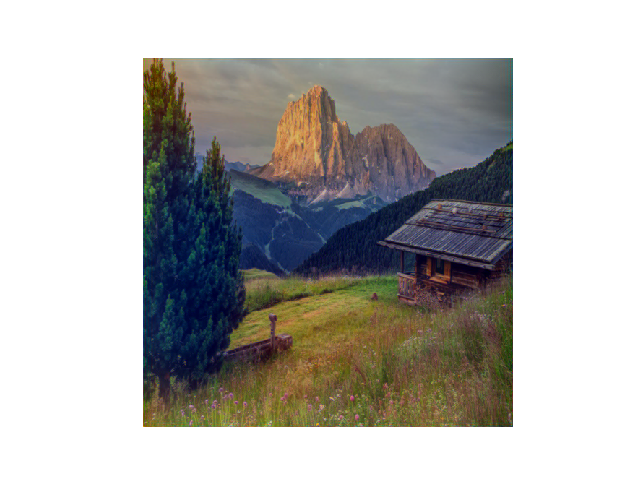

<IPython.core.display.Javascript object>


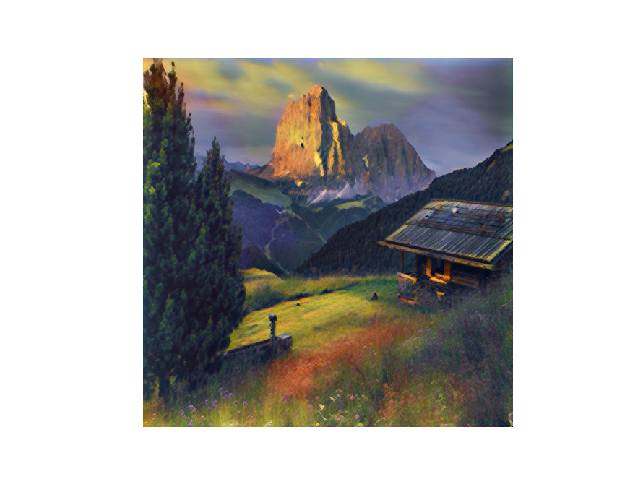

<IPython.core.display.Javascript object>


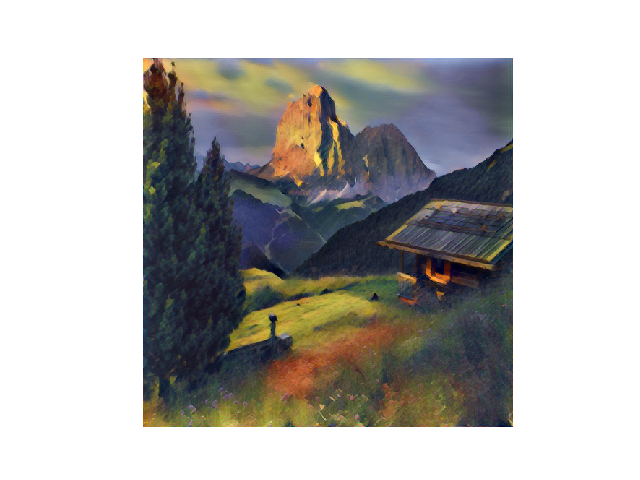

<IPython.core.display.Javascript object>


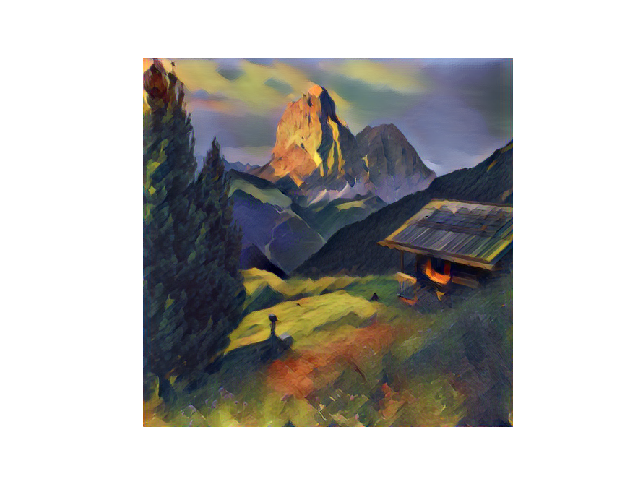

<IPython.core.display.Javascript object>


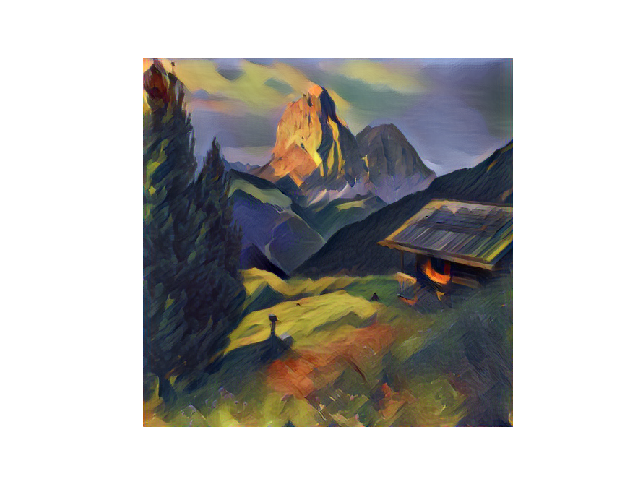

In [16]:
contentLayers = ['conv_4']
styleLayers = [['conv_1'],['conv_1', 'conv_2'],['conv_1', 'conv_2', 'conv_3'],['conv_1', 'conv_2', 'conv_3', 'conv_4'],['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']]
for i in range(len(styleLayers)):
    outputImg, loss1, loss2 = trainer(contentImg, styleImg, 300, vgg, contentLayers, styleLayers[i], 10000)
    plt.figure()
    myimshow(outputImg.detach(), ax=plt)

<IPython.core.display.Javascript object>


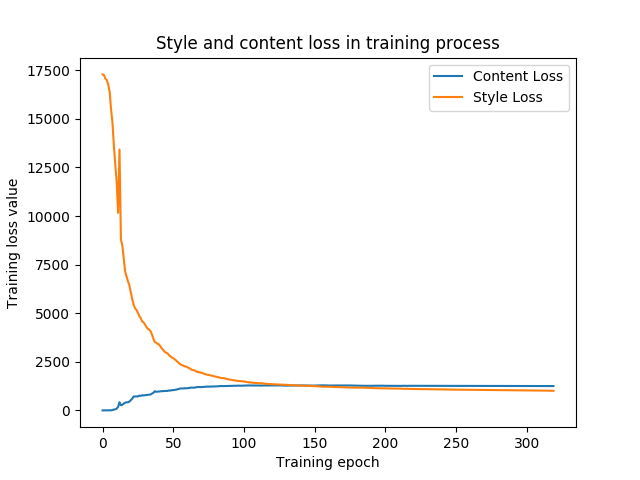

In [19]:
plt.figure()
ln1 = plt.plot([loss1[k] for k in range(len(loss1))],label = "Content Loss")
ln2 = plt.plot([loss2[k] for k in range(len(loss2))],label = "Style Loss")
plt.xlabel('Training epoch')
plt.ylabel('Training loss value')
plt.title('Style and content loss in training process')
plt.legend()
plt.show()